In [3]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, PillowWriter
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

In [4]:
class CustomDataset(Dataset):
    def __init__(self, images: str, labels: str, transforms):
        self.images = np.load(images, allow_pickle=True)
        self.labels = np.load(labels, allow_pickle=True)
        print("Images' shape: (%d, %d, %d, %d)" % self.images.shape)
        print("Labels' shape: (%d, %d)" % self.labels.shape)
        self.transforms = transforms

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        image = self.images[index]
        label = torch.tensor(self.labels[index], dtype=torch.int64)
        if self.transforms:
            image = self.transforms(image)
        return (image, label)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, skip: bool = False) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.skip = skip

        if self.in_channels != self.out_channels:
            self.shortcut = nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            )
        else:
            self.shortcut = nn.Identity()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # same size
            nn.BatchNorm2d(num_features=out_channels),
            nn.GELU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),  # same size
            nn.BatchNorm2d(num_features=out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.conv1(x)
        out = self.conv2(x1)
        if self.skip:
            out = self.shortcut(x) + out
        return out


class UnetDown(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            ResidualConvBlock(in_channels=in_channels, out_channels=out_channels),
            ResidualConvBlock(in_channels=out_channels, out_channels=out_channels),
            nn.MaxPool2d(2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            ResidualConvBlock(in_channels=out_channels, out_channels=out_channels),
            ResidualConvBlock(in_channels=out_channels, out_channels=out_channels),
        )

    def forward(self, x: torch.Tensor, skip_tensor: torch.Tensor) -> torch.Tensor:
        x = torch.cat([x, skip_tensor], dim=1)

        x = self.layers(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim: int, embed_dim: int) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim

        self.layers = nn.Sequential(
            nn.Linear(input_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, self.input_dim)
        return self.layers(x)

In [6]:
class ContextUnet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_dim: int = 256,
        context_feature_dim: int = 10,
        size: int = 28,
    ) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.hidden_dim = hidden_dim
        self.context_feature_dim = context_feature_dim
        self.size = size  #assume h == w. must be divisible by 4, so 28,24,20,16...

        self.init_conv = ResidualConvBlock(
            in_channels=in_channels,
            out_channels=hidden_dim,
            skip=True
        )

        self.down1 = UnetDown(hidden_dim, hidden_dim)   # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(hidden_dim, 2 * hidden_dim)  # down2 #[10, 256, 4,  4]

        # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(
            nn.AvgPool2d(4),
            nn.GELU(),
        )

        # embed timestep
        self.time_embed_1 = EmbedFC(1, 2 * hidden_dim)
        self.time_embed_2 = EmbedFC(1, 1 * hidden_dim)

        # embed context label
        self.context_embed_1 = EmbedFC(context_feature_dim, 2 * hidden_dim)
        self.context_embed_2 = EmbedFC(context_feature_dim, hidden_dim)

        self.up0 = nn.Sequential(
            nn.Upsample(scale_factor=4),
            nn.Conv2d(
                in_channels=2 * hidden_dim,
                out_channels=2 * hidden_dim,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.GroupNorm(
                num_groups=8,
                num_channels=2 * hidden_dim
            ),
            nn.ReLU(),
        )

        self.up1 = UnetUp(
            in_channels=4 * hidden_dim,
            out_channels=hidden_dim
        )
        self.up2 = UnetUp(
            in_channels=2 * hidden_dim,
            out_channels=hidden_dim
        )

        self.out = nn.Sequential(
            nn.Conv2d(
                in_channels=2 * hidden_dim,
                out_channels=hidden_dim,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_dim
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_dim,
                out_channels=self.in_channels,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
        )

    def forward(
        self,
        image: torch.Tensor,
        timesteps: torch.Tensor,
        context_label: Optional[None | torch.Tensor] = None,
    ) -> torch.Tensor:
        x = self.init_conv(image)

        down1 = self.down1(x)
        down2 = self.down2(down1)

        latent = self.to_vec(down2)

        if context_label is None:
            context_label = torch.zeros(x.shape[0], self.context_feature_dim).to(x.device)
        # context
        context_embed_1 = self.context_embed_1(context_label).view(-1, self.hidden_dim * 2, 1, 1)

        context_embed_2 = self.context_embed_2(context_label).view(-1, self.hidden_dim, 1, 1)
        # timesteps
        time_embed_1 = self.time_embed_1(timesteps).view(-1, self.hidden_dim * 2, 1, 1)
        time_embed_2 = self.time_embed_2(timesteps).view(-1, self.hidden_dim, 1, 1)

        up1 = self.up0(latent)
        up2 = self.up1(context_embed_1 * up1 + time_embed_1, down2)
        up3 = self.up2(context_embed_2 * up2 + time_embed_2, down1)

        out = self.out(torch.cat([up3, x], dim=1))
        return out


In [7]:
timesteps = 500
beta_start = 1e-4
beta_end = 0.02

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hidden_dim = 64
context_dim = 5
size = 16
batch_size = 100
n_epoch = 32
lr = 1e-3

In [40]:
def denormalize_and_clip(image: torch.Tensor) -> torch.Tensor:
    image *= 0.5
    image += 0.5
    return image.clip(0, 1)


class NoiseScheduler(nn.Module):
    def __init__(
        self,
        timesteps: int = 24,
        beta_start: float = 1e-4,
        beta_end: float = 0.6
    ):
        super().__init__()
        self.timesteps = timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        beta = torch.linspace(beta_start, beta_end, timesteps)
        alpha = 1. - beta
        alpha_bar = torch.cumprod(alpha, 0)

        self.register_buffer('beta', beta)
        self.register_buffer('alpha', alpha)
        self.register_buffer('alpha_bar', alpha_bar)

    def add_noise(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
        noise: torch.Tensor
    ) -> torch.Tensor:
        """
        Adds a single step of noise
        :param x: image we are adding noise to
        :param t: step number, 0 indexed (0 <= t < steps)
        :return: image with noise added
        """
        alpha_bar = self.alpha_bar[t].view(-1, 1, 1, 1)
        return torch.sqrt(alpha_bar) * x + torch.sqrt(1 - alpha_bar) * noise

    def sample_prev_step(
        self,
        xt: torch.Tensor,
        t: torch.Tensor,
        pred_noise: torch.Tensor
    ) -> torch.Tensor:
        z = torch.randn_like(xt)
        z[t.expand_as(z) == 0] = 0

        mean = (1 / torch.sqrt(self.alpha[t])) * (xt - (self.beta[t] / torch.sqrt(1 - self.alpha_bar[t])) * pred_noise)
        var = ((1 - self.alpha_bar[t - 1])  / (1 - self.alpha_bar[t])) * self.beta[t]
        sigma = torch.sqrt(var)

        x = mean + sigma * z
        return x

    def ddim(
        self,
        xt: torch.Tensor,
        t: torch.Tensor,
        t_prev: torch.Tensor,
        pred_noise: torch.Tensor,
        eta: float = 0.0  # 0.0 = deterministic; 1.0 = stochastic (matches DDPM)
    ) -> torch.Tensor:
        """
        DDIM reverse step (deterministic by default).
        Assumes t and t_prev are tensors of shape (batch_size,) or broadcastable.
        """
        # Validate inputs
        assert t.shape == t_prev.shape, "t and t_prev must have matching shapes"
        assert (t_prev < t).all(), "t_prev must be < t for valid reverse steps"
        assert 0 <= eta <= 1, "eta must be in [0, 1]"

        # Extract alphas (broadcast to match xt)
        ab_t = self.alpha_bar[t].view(-1, 1, 1, 1)  # (batch, 1, 1, 1)
        ab_tprev = self.alpha_bar[t_prev].view(-1, 1, 1, 1)

        # Step 1: Predict hat_x0 correctly
        sqrt_ab_t = torch.sqrt(ab_t)
        x0_pred = (xt - torch.sqrt(1 - ab_t) * pred_noise) / sqrt_ab_t  # Now a true hat_x0

        # If t_prev would be negative, just return x0
        if t_prev[0] < 0:
            return x0_pred

        # Step 2: Compute direction (always added)
        dir_xt = torch.sqrt(1 - ab_tprev) * pred_noise

        # Step 3: Deterministic part
        x_tprev = torch.sqrt(ab_tprev) * x0_pred + dir_xt

        # Step 4: Optional stochastic noise (DDIM variance)
        if eta > 0:
            sigma_t = eta * torch.sqrt(
                (1 - ab_tprev) / (1 - ab_t) * (1 - ab_t / ab_tprev)
            ) * torch.sqrt(1 - ab_t)  # Full DDIM sigma formula
            z = torch.randn_like(xt)
            x_tprev += sigma_t * z

        return x_tprev

In [41]:
noise_scheduler = NoiseScheduler(timesteps, beta_start, beta_end).to(device)

nn_model = ContextUnet(
    in_channels=3,
    hidden_dim=hidden_dim,
    context_feature_dim=context_dim,
    size=size
).to(device)

In [10]:
dataset = CustomDataset("sprites_1788_16x16.npy", "sprite_labels_nc_1788_16x16.npy", transforms=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.AdamW(nn_model.parameters(), lr=lr)

Images' shape: (89400, 16, 16, 3)
Labels' shape: (89400, 5)


In [ ]:
criterion = nn.MSELoss()
nn_model.train()

for epoch in range(n_epoch):

    # Decay learning rate
    optim.param_groups[0]["lr"] = lr * (1 - epoch / n_epoch)

    pbar = tqdm(dataloader, mininterval=2)
    losses = []
    for x, label in pbar:
        optim.zero_grad()

        x = x.to(device)
        label = label.to(device=device, dtype=torch.float32)

        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps, (x.shape[0],), device=device)
        x_pert = noise_scheduler.add_noise(x, t, noise)

        pred_noise = nn_model(x_pert, t / timesteps, label)

        loss = criterion(pred_noise, noise)
        loss.backward()

        optim.step()

        losses.append(loss.detach().cpu().item())
    if epoch % 4 == 0 or epoch == n_epoch - 1:
        print(f"Epoch {epoch} - Loss {np.mean(losses)}")

In [43]:
@torch.no_grad()
def sample_ddpm(
    context: torch.Tensor,
    n_sample: int,
    channels: int = 3,
    size: int = 16,
    save_rate: int = 20
):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, channels, size, size).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps - 1, 0, -1):
        print(f'Sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t, context)
        tensor_i = torch.tensor(i, device=device).view(1,)
        samples = noise_scheduler.sample_prev_step(samples, tensor_i, eps)
        if i % save_rate ==0 or i == timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

#### Quick Recap: What DDIM Does
- Denoising Diffusion Implicit Models [DDIM] accelerates diffusion sampling by allowing **step skipping** (e.g., from timestep `t` directly to `t_prev`, where `t_prev < t`, not necessarily `t-1`).
- It predicts the "clean" image $\hat{x}_0$ from the noisy $x_t$ and predicted noise $\epsilon_\theta(x_t, t)$.
- The update is **deterministic** by default (no added noise `z`), but can be made stochastic by introducing variance $\sigma_t$.
- Your forward process uses $\bar{\alpha}_t$ (cumulative product of $\alpha_t = 1 - \beta_t$), which is correct.

#### Standard Deterministic DDIM Formula
For a single step from $x_t$ to $x_{t-1}$ (or more generally, to $x_{t_{prev}}$):

1. Predict the clean sample:
   $$
   \hat{x}_0 = \frac{x_t - \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon_\theta(x_t, t)}{\sqrt{\bar{\alpha}_t}}
   $$

2. Update to the previous timestep (deterministic, $\sigma_t = 0$):
   $$
   x_{t_{prev}} = \sqrt{\bar{\alpha}_{t_{prev}}} \cdot \hat{x}_0 + \sqrt{1 - \bar{\alpha}_{t_{prev}}} \cdot \epsilon_\theta(x_t, t)
   $$

- This is **directional** (the second term is like a "direction" pointing toward the predicted noise).
- For stochastic DDIM, add $\sigma_t \cdot z$ where $z \sim \mathcal{N}(0, I)$ and $\sigma_t = \eta \sqrt{(1 - \bar{\alpha}_{t_{prev}}) / (1 - \bar{\alpha}_t)} \sqrt{1 - \bar{\alpha}_t / \bar{\alpha}_{t_{prev}}}$ (with $\eta \in [0, 1]$; $\eta=0$ is deterministic).


#### Additional Tips
- **Integration**: In your sampling loop, call this iteratively: start from `x_T ~ N(0, I)`, then for `t` in reversed timesteps, compute `pred_noise = model(x_t, t)`, then `x_{t_prev} = self.ddim(x_t, t, t_prev, pred_noise)`.
- **Skipping Steps**: For faster sampling, set `t_prev` to skip (e.g., `t_prev = t * 0.5` for 2x speedup).
- **Debugging**: Print norms/shapes of `x0_pred` and final output— they should stay in reasonable ranges (e.g., after denormalization).
- **Resources**: [DDIM paper](https://arxiv.org/abs/2010.02502) or Hugging Face Diffusers' [DDIM implementation](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py) for reference.


In [33]:
@torch.no_grad()
def sample_ddim(
    context: torch.Tensor,
    n_sample: int,
    n_step: int,
    channels: int = 3,
    size: int = 16,
    save_rate: int = 20,
):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, channels, size, size).to(device)
    step_size = timesteps // n_step

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps - 1, 0, -step_size):
        print(f'Sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t, context)
        tensor_i = torch.tensor(i, device=device).view(1,)
        samples = noise_scheduler.ddim(samples, tensor_i, tensor_i - step_size, eps)
        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [38]:
def plot_sample(x_gen_store, n_sample, nrows, save_dir, fn):
    ncols = n_sample // nrows
    sx_gen_store = np.moveaxis(x_gen_store, 2, 4)  # change to Numpy image format (h,w,channels) vs (channels,h,w)
    nsx_gen_store = denormalize_and_clip(sx_gen_store)
    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        sharex=True,
        sharey=True,
        figsize=(ncols, nrows)
    )
    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[i, (row * ncols) + col]))
        return plots
    ani = FuncAnimation(
        fig,
        animate_diff,
        fargs=[nsx_gen_store],
        interval=200,
        blit=False,
        repeat=True,
        frames=nsx_gen_store.shape[0]
    )
    plt.close()
    ani.save(save_dir + f"{fn}.gif", dpi=100, writer=PillowWriter(fps=5))
    return ani

In [42]:
nn_model.eval()
context_features = F.one_hot(
    torch.randint(0, 5, (32,)), 5
).to(device=device, dtype=torch.float32)

plt.clf()
samples, intermediate_ddpm = sample_ddim(context_features, 32, 20)
save_dir = "/content/"
animation_ddpm = plot_sample(intermediate_ddpm, 32, 4, save_dir, "ani_run")
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [44]:
def show_images(images, context_labels, nrow: int = 2):
    _, axs = plt.subplots(nrow, images.shape[0] // nrow, figsize=(5, 3))
    axs = axs.flatten()
    for image, ax, y in zip(images, axs, context_labels):
        image = denormalize_and_clip(image.permute(1, 2, 0)).detach().cpu()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(y)
        ax.imshow(image)
    plt.show()

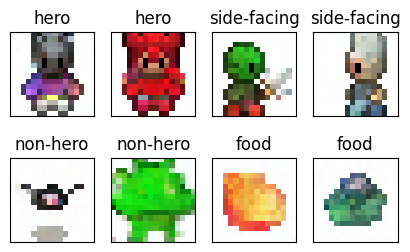

In [45]:
context = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
])

labels = ["hero", "non-hero", "food", "spell", "side-facing"]

context_labels = [labels[y] for y in context.argmax(-1)]

context = context.float().to(device)

samples, _ = sample_ddpm(context, context.shape[0])
show_images(samples, context_labels)

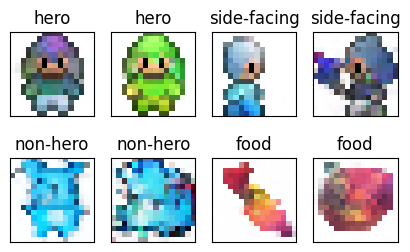

In [46]:
context = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
])


labels = ["hero", "non-hero", "food", "spell", "side-facing"]

context_labels = [labels[y] for y in context.argmax(-1)]

context = context.float().to(device)

samples, _ = sample_ddim(context, context.shape[0], 20)
show_images(samples, context_labels)

## Compare DDPM vs DDIM

###  Determinism vs. Stochasticity
DDPM sampling is inherently stochastic. At each step
$t$, the reverse transition $p_\theta​(x_{t−1}​∣x_t​ )$ involves sampling, typically by adding Gaussian noise scaled by a variance term $\sigma_t^2$
 . This means that even starting from the same initial noise $x_T$
 , running the DDPM sampling process multiple times will produce different final samples $x_0$. This stochasticity contributes to the diversity of generated samples.

DDIM introduces a parameter, often denoted as $\eta$, which controls the amount of stochasticity in the sampling process.

- When $\eta=1$, the DDIM process behaves similarly to DDPM in terms of stochasticity (though using the DDIM update rule).
- When $\eta=0$, the DDIM sampling process becomes deterministic. Given the same initial noise $x_T$, running DDIM with $\eta=0$ will always produce the exact same final sample $x_0$. This is because the random noise term in the update step vanishes when $\eta=0$.
This deterministic property ($\eta=0$) is useful for applications requiring reproducibility or for tasks like image inversion and manipulation where you want a predictable mapping between the latent noise and the generated image. Values between 0 and 1 allow interpolating between deterministic and stochastic generation.

### Flexibility in Step Sizes
DDPM sampling follows the predefined sequence of timesteps $T,T−1,...,1.$. It doesn't easily allow for varying the "size" of the steps taken during denoising.

DDIM's formulation provides more flexibility. By allowing sampling using a subsequence of the original timesteps, DDIM effectively allows for larger, non-uniform steps in the denoising process. This is mathematically justified by its connection to solving differential equations, where step sizes can be adapted.

### Generation Speed
DDPM sampling, as originally formulated, requires simulating the reverse Markov chain step-by-step. If the model was trained for $T$ timesteps (often $T=1000$ or more), DDPM sampling involves $T$ sequential evaluations of the neural network. This makes the process computationally intensive and relatively slow, as each step depends on the previous one.DDIM offers a significant advantage here. Because DDIM formulates the generation process differently (related to solving an underlying differential equation), it doesn't strictly require simulating every single timestep from the original forward process sequence $1, ..., T$. Instead, you can choose a subsequence of timesteps, say $S < T$ steps (e.g., $S=50, 100, 200$), and perform the denoising updates only at these selected timesteps. This drastically reduces the number of required network evaluations, leading to much faster sample generation. For instance, using DDIM with 100 steps can be 10 times faster than using DDPM with 1000 steps.

### Summary table

| Feature       | DDPM                               | DDIM                                                          |
|---------------|------------------------------------|---------------------------------------------------------------|
| Speed         | Slow (Requires T steps)            | Fast (Can use S << T steps)                                   |
| Quality       | High (especially with many steps)  | Good (Often comparable with fewer steps, degrades if too few) |
| Stochasticity | Always Stochastic                  | Controlled by ηη; Deterministic if η = 0η=0                   |
| Step Size     | Fixed (Follows original T steps)   | Flexible (Uses subsequence of steps)                          |
| Use Case      | Max fidelity, diversity generation | Faster generation, interactive use, deterministic outputs     |


### Choosing Between DDPM and DDIM:

- If your primary goal is to generate the highest possible quality samples and computational time is not a major constraint, **DDPM** (with a large T) is a strong choice.
- If you need faster generation, for example, for interactive applications or generating large batches of images quickly, **DDIM** (with a moderate number of steps, e.g., 50-200) is generally preferred.
- If you require deterministic outputs from the same starting noise (e.g., for reproducibility or controlled editing), **DDIM** with
$\eta = 0$ is the method to use.  

In practice, **DDIM** is very widely used due to its significant speed advantage while often maintaining excellent sample quality. Understanding these trade-offs allows you to select the sampling method that best aligns with the requirements of your specific generative task.

In [52]:
nn_model.eval()
context_features = F.one_hot(
    torch.randint(0, 5, (32,)), 5
).to(device=device, dtype=torch.float32)

%timeit -r 1 sample_ddim(context_features, context_features.shape[0], 20)
%timeit -r 1 sample_ddpm(context_features, context_features.shape[0])

86.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2.21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#